In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/08 11:41:50 WARN Utils: Your hostname, mugis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.13.29.210 instead (on interface en0)
22/10/08 11:41:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 11:41:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/08 11:41:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/08 11:41:52 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/08 11:41:52 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
df = spark.read.parquet("../data/curated/merchant_consumer_abs")

In [4]:
revenue_monthly = df.groupBy(["merchant_name", "order_year", "order_month"]).agg(sum("dollar_value").alias("total_dollar_value"))
revenue_annually = df.groupBy(["merchant_name", "order_year"]).agg(sum("dollar_value").alias("total_dollar_value"))

In [5]:
revenue_monthly = revenue_monthly.toPandas()
revenue_annually = revenue_annually.toPandas()

In [6]:
revenue_monthly = revenue_monthly.sort_values(["merchant_name", "order_year", "order_month"])
revenue_annually = revenue_annually.sort_values(["merchant_name", "order_year"])

In [7]:
merchants = list(set(revenue_monthly["merchant_name"].unique()))

/var/folders/dn/1fknx8rs59q6l9qq0_99db6m0000gn/T/ipykernel_1606/2722310543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)


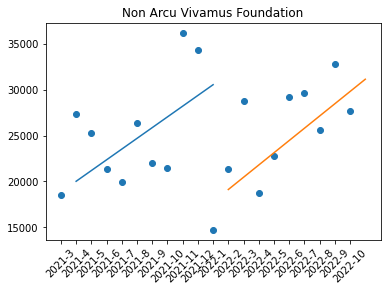

/var/folders/dn/1fknx8rs59q6l9qq0_99db6m0000gn/T/ipykernel_1606/2722310543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)
/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3397: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


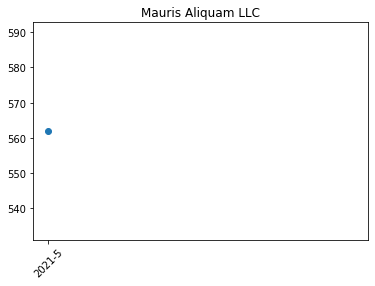

/var/folders/dn/1fknx8rs59q6l9qq0_99db6m0000gn/T/ipykernel_1606/2722310543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)


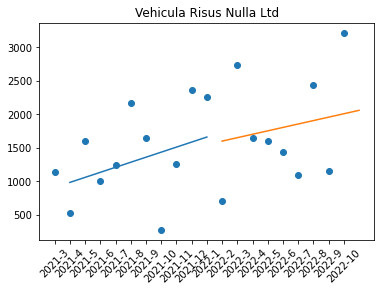

/var/folders/dn/1fknx8rs59q6l9qq0_99db6m0000gn/T/ipykernel_1606/2722310543.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)


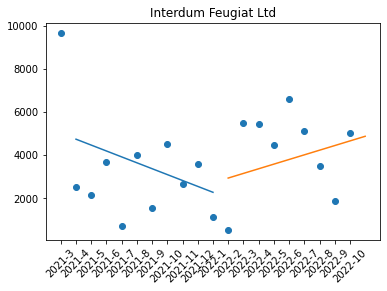

In [8]:
for i in range(600, 604):
    merchant = revenue_monthly[revenue_monthly["merchant_name"] == merchants[i]]
    merchant["period"] = merchant["order_year"].astype(str) + "-" + merchant["order_month"].astype(str)
    x = merchant['period']
    y = merchant['total_dollar_value']
    plt.scatter(x, y)
    
    year21 = len(merchant[merchant["order_year"] == 2021])
    if (year21 != 0):
        xNum1 = np.array(range(1, year21+1))
        a1, b1 = np.polyfit(xNum1, y[:year21], 1)
        plt.plot(xNum1, a1*xNum1+b1)

    year22 = len(merchant[merchant["order_year"] == 2022])
    if (year22 != 0):
        xNum2 = np.array(range(year21+1, len(x)+1))
        a2, b2 = np.polyfit(xNum2, y[year21:len(x)], 1)
        plt.plot(xNum2, a2*xNum2+b2)
    
    plt.xticks(rotation=45)
    plt.title(merchants[i])
    plt.show()

In [9]:
revenue_increasing = []
count = 0
for i in range(len(merchants)):
    merchant_increasing = []
    merchant = revenue_annually[revenue_annually["merchant_name"] == merchants[i]]
    merchant_increasing.append(merchants[i])
    if len(merchant) == 1:
        count+=1
        if ((merchant["order_year"] == 2022).values):
            merchant_increasing.append((merchant["total_dollar_value"]).values[0]/10)
            revenue_increasing.append(merchant_increasing)
        if ((merchant["order_year"] == 2021).values):
            merchant_increasing.append(-((merchant["total_dollar_value"]).values[0]/10))
            revenue_increasing.append(merchant_increasing)
    if len(merchant) == 2:
        merchant_increasing.append(((merchant[merchant["order_year"] == 2022]["total_dollar_value"]).values - (merchant[merchant["order_year"] == 2021]["total_dollar_value"]).values)[0]/10)
        revenue_increasing.append(merchant_increasing)

In [10]:
result = pd.DataFrame(revenue_increasing, columns=["merchant_name", "monthly_increase_rate"])
result

,merchant_name,monthly_increase_rate
0,Dis Parturient Montes Industries,-89.232306
1,Posuere At Velit Incorporated,-2188.963038
2,Sed Pharetra Ltd,-126.066301
3,A Magna Lorem Ltd,2517.521238
4,Accumsan Corporation,-22.824730
...,...,...
3890,Euismod Ac Fermentum Ltd,-189.043619
3891,Erat Volutpat Corp.,-393.309491
3892,Venenatis Lacus Etiam Corporation,354.546547
3893,Arcu Limited,-1542.702999


In [11]:
result.to_csv("../data/curated/increasing.csv", index = False)